In [1]:
import lettuce as lt
from lettuce import D3Q19, UnitConversion
import csv
from lettuce.util.moments import D3Q19ChavezTransform
from lettuce import Observable
from lettuce.ext._boundary.wallfunction import WallFunction
from lettuce.ext._reporter.observable_reporter import GlobalMeanUXReporter, WallQuantities, AdaptiveAcceleration, WallfunctionReporter
from lettuce.ext._stencil.d3q19 import D3Q19


In [2]:
import site
import os
import shutil

packages_dirs = site.getsitepackages()
if not isinstance(packages_dirs, list):
    packages_dirs = [packages_dirs]

print(f"Durchsuche 'site-packages' in: {packages_dirs}")
found = False

for packages_dir in packages_dirs:
    if not os.path.isdir(packages_dir):
        continue

    for d in os.listdir(packages_dir):
        if d.startswith('lettuce_'):
            full_path = os.path.join(packages_dir, d)
            print(f"  -> GEFUNDEN (und wird gelöscht): {full_path}")

            try:
                shutil.rmtree(full_path)

                # Auch die .egg-info-Datei löschen
                egg_info = full_path.replace('.egg', '') + f"-py{sys.version_info.major}.{sys.version_info.minor}.egg-info"
                if os.path.exists(egg_info):
                    shutil.rmtree(egg_info)
                    print(f"     ... Zugehörige .egg-info gelöscht.")

                print(f"     ... Erfolgreich gelöscht.")
                found = True
            except PermissionError:
                print(f"     ... FEHLER: Keine Berechtigung. Lösche den Ordner manuell: {full_path}")
            except Exception as e:
                print(f"     ... FEHLER beim Löschen: {e}")

if not found:
    print("Keine alten 'lettuce_' Kernel-Module gefunden. (Das ist gut, wenn du zum ersten Mal kompilierst)")

Durchsuche 'site-packages' in: ['/home/ben/lettuce/.venv/lib/python3.12/site-packages']
Keine alten 'lettuce_' Kernel-Module gefunden. (Das ist gut, wenn du zum ersten Mal kompilierst)


In [3]:
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter
import numpy as np
import torch

parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
parser.add_argument("--vtkdir", type=str, default="./output/")
parser.add_argument("--csvdir", type=str, default="./output/")
parser.add_argument("--nout", type=int, default=100)
parser.add_argument("--nvtk", type=int, default=100)
parser.add_argument("--tmax", type=int, default=1)
parser.add_argument("--Re", type=int, default=180)
parser.add_argument("--collision_operator", type=str, default="BGK")
parser.add_argument("--Precision", type=str, default="Double")
parser.add_argument("--Mach", type=float, default=0.1)
parser.add_argument("--h", type=int, default=12, help="Halbe Kanalhöhe in LU")
parser.add_argument("--bbtype", type=str, default="wallfunction", choices=["halfway", "fullway", "wallfunction", "freeslip"],
                    help="Typ der Bounce-Back-Randbedingung")
parser.add_argument("--use_native", type=bool, default=True)
args, unknown = parser.parse_known_args()
args = vars(args)

print("ICH FUNKTIONIERE MIT PULLEN")



# Einheiten und Auflösung
h = args["h"]                      # Kanalhalbhöhe in LU
res_y = 2 * h                     # y: volle Kanalhöhe
res_x = int(2*np.pi * h)
res_z = int(np.pi * h)

# Restliche Parameter
Re = args["Re"]
basedir = args["vtkdir"]
csvdir = args["csvdir"]
nout = args["nout"]
nvtk = args["nvtk"]
tmax = args["tmax"]
Precision = args["Precision"]
collision_operator = args["collision_operator"]
Mach = args["Mach"]
bbtype = args["bbtype"]
h = args["h"]
use_native = args["use_native"]
# Präzision
if Precision == "Single":
    dtype = torch.float32
elif Precision == "Double":
    dtype = torch.float64
elif Precision == "Half":
    dtype = torch.float16
print(use_native)
print(torch.cuda.is_available())
print(torch.version.cuda)

ICH FUNKTIONIERE MIT PULLEN
True
True
13.0


In [4]:
context = lt.Context(device=torch.device('cuda:0') if torch.cuda
                     .is_available() else torch.device('cpu'),
                     dtype=dtype, use_native = True)

flow = lt.ChannelFlow3D(
    context = context,
    resolution=h,
    reynolds_number=6432 if Re == 180 else Re**(8/7)*(8/0.073)**(4/7),
    stencil = D3Q19(),
    mach_number=Mach,
    bbtype=bbtype if use_native is False else None
)

In [5]:
shape = flow.resolution
mask_bottom = torch.zeros(shape, dtype=torch.bool, device=context.device)
mask_bottom[:, 0, :] = True
mask_top = torch.zeros(shape, dtype=torch.bool, device=context.device)
mask_top[:, -1, :] = True
mask_force = torch.ones(shape, dtype=torch.bool, device=context.device)
mask_force[:, 0, :] = True
mask_force[:, -1, :] = True

global_mean_ux_reporter = GlobalMeanUXReporter(flow = flow)

from lettuce.ext._force.Kupershtokh import ExactDifferenceForce
force = ExactDifferenceForce(flow  =flow, acceleration=[0,0,0])


adaptive_accel = AdaptiveAcceleration(
    flow=flow,
    force_obj=force,  # 🔗 direkte Verbindung!
    target_mean_ux_lu=flow.units.convert_velocity_to_lu(1.0),
    context=context,
    k_gain=1.0
)

if collision_operator == "BGK":

    collision = lt.BGKCollision(tau=flow.units.relaxation_parameter_lu, force=None)

elif collision_operator == "Smag":
    
    collision = lt.SmagorinskyCollision(tau=flow.units.relaxation_parameter_lu, force=force)
print(flow.boundaries)

[]


In [6]:
simulation = lt.Simulation(flow=flow, collision=collision, reporter = [])

if use_native:
    mask_no_collision = torch.zeros(flow.resolution, dtype=torch.bool, device=context.device)
    # Wand + erste Fluidreihe (keine Kollision dort)
    mask_no_collision[:, 0, :] = True
    mask_no_collision[:, 1, :] = True
    mask_no_collision[:, -1, :] = True
    mask_no_collision[:, -2, :] = True

    simulation.no_collision_mask = mask_no_collision
    simulation.no_streaming_mask = None

Could not resolve cuda_native extension.

--- NATIVE KERNEL GENERATOR (KORREKTE, VEREINFACHTE VERSION) ---
Status: Compiling WITHOUT forcing.
--------------------------------------------------

Installing Native module (/tmp/tmp8422j7xo) ...


/home/ben/lettuce/lettuce/_simulation.py:60: UserWarning: This warning occurs because either post_boundaries is not defined withinthe flow class or the `boundaries` method is usedwhich is deprecated and will be removed in a future version. Please use `pre_boundaries` or `post_boundaries` directly instead.
  self.transformer = (flow.pre_boundaries or []) + [collision] + (flow.post_boundaries or [])
/home/ben/lettuce/lettuce/_simulation.py:63: UserWarning: This warning occurs because either post_boundaries is not defined withinthe flow class or the `boundaries` method is usedwhich is deprecated and will be removed in a future version. Please use `pre_boundaries` or `post_boundaries` directly instead.
  self.post_boundaries = flow.post_boundaries


In [7]:

wq_bottom = WallQuantities(mask = mask_bottom, wall = "bottom", flow=flow, context = context)
wq_top = WallQuantities(mask = mask_top, wall = "top", flow=flow, context = context)


simulation.reporter.append(lt.ObservableReporter(global_mean_ux_reporter, interval=1, out=None))
simulation.reporter.append(lt.ObservableReporter(wq_bottom, interval=100, out=None))
simulation.reporter.append(lt.ObservableReporter(wq_top, interval=100, out=None))
simulation.reporter.append(lt.ObservableReporter(adaptive_accel, interval=50, out=None))
steps = int(flow.units.convert_time_to_lu(tmax))
vtk_reporter = lt.VTKReporter(interval=max(1, int(steps/100)), filename_base=basedir + "/output_h20_t30")
simulation.reporter.append(vtk_reporter)

if use_native:
    collision_py = lt.BGKCollision(tau=flow.units.relaxation_parameter_lu, force=force)
    wfb_bottom = WallFunction(mask_bottom, flow.stencil, h, context, wall="bottom")
    wfb_top = WallFunction(mask_top, flow.stencil, h, context, wall="top")
    
    # -------------------
    # Reporter (macht Python-Kollision + WFB)
    # -------------------
    mask_no_collision2 = torch.ones(flow.resolution, dtype=torch.bool, device=context.device)
    #mask_no_collision2[:, :, :] = True
    mask_no_collision2[:, 1, :] = False
    mask_no_collision2[:, -2, :] = False
    wfb_reporter = WallfunctionReporter(context, flow, collision_py, mask_no_collision2, wfb_bottom, wfb_top)
    simulation.reporter.append(lt.ObservableReporter(wfb_reporter, interval=1, out=None))

In [8]:
print("f:", flow.f.shape, flow.f.device, flow.f.dtype)
print("f_next:", flow.f_next.shape, flow.f_next.device, flow.f_next.dtype)

print("acc (vorher):", force.acceleration.shape, force.acceleration.device, force.acceleration.dtype, force.acceleration.is_contiguous())

# HART angleichen
force.acceleration = (
    force.acceleration
    .to(device=flow.f.device, dtype=flow.f.dtype)
    .contiguous()
)

# Länge absichern (d = 2/3)
d = flow.stencil.d
assert force.acceleration.dim() == 1, "force.acceleration muss 1D sein"
assert force.acceleration.numel() >= d, f"force.acceleration muss mindestens Länge {d} haben"

print("acc (nachher):", force.acceleration.shape, force.acceleration.device, force.acceleration.dtype, force.acceleration.is_contiguous())


f: torch.Size([19, 80, 24, 40]) cuda:0 torch.float64
f_next: torch.Size([19, 80, 24, 40]) cuda:0 torch.float64
acc (vorher): torch.Size([3]) cuda:0 torch.float64 True
acc (nachher): torch.Size([3]) cuda:0 torch.float64 True


In [9]:

mlups = simulation.step(num_steps=steps)

wq_top_arr = np.array(simulation.reporter[2].out)
wq_bottom_arr = np.array(simulation.reporter[1].out)
ux_mean_arr = np.array(simulation.reporter[0].out)

with open(csvdir + 'uxmean.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(ux_mean_arr)
with open(csvdir + 'WallQuantitiesTop.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(wq_top_arr)
with open(csvdir + 'WallQuantitiesBottom.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(wq_bottom_arr)

y+: tensor(6.8995, device='cuda:0', dtype=torch.float64) Re_tau: tensor(82.7936, device='cuda:0', dtype=torch.float64)
y+: tensor(6.9033, device='cuda:0', dtype=torch.float64) Re_tau: tensor(82.8397, device='cuda:0', dtype=torch.float64)
[Schritt 0] REPORTER LÄUFT. Berechnete Fx = 1.008233e-04 (Target_u: 0.058, Actual_u: 0.037)


/home/ben/lettuce/lettuce/ext/_boundary/wallfunction.py:159: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /pytorch/aten/src/ATen/native/IndexingUtils.h:37.)
  f17_old = flow.f[17, self.mask].clone()
/home/ben/lettuce/lettuce/ext/_boundary/wallfunction.py:160: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /pytorch/aten/src/ATen/native/IndexingUtils.h:37.)
  f16_old = flow.f[16, self.mask].clone()
/home/ben/lettuce/lettuce/ext/_boundary/wallfunction.py:161: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /pytorch/aten/src/ATen/native/IndexingUtils.h:37.)
  f10_old = flow.f[10, self.mask].clone()
/home/ben/lettuce/lettuce/ext/_boundary/wallfunction.py:162: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool

[Schritt 50] REPORTER LÄUFT. Berechnete Fx = 1.020913e-04 (Target_u: 0.058, Actual_u: 0.037)
y+: tensor(3.9491, device='cuda:0', dtype=torch.float64) Re_tau: tensor(47.3896, device='cuda:0', dtype=torch.float64)
y+: tensor(3.9459, device='cuda:0', dtype=torch.float64) Re_tau: tensor(47.3507, device='cuda:0', dtype=torch.float64)
[Schritt 100] REPORTER LÄUFT. Berechnete Fx = 1.053155e-04 (Target_u: 0.058, Actual_u: 0.036)
[Schritt 150] REPORTER LÄUFT. Berechnete Fx = 1.069344e-04 (Target_u: 0.058, Actual_u: 0.036)
y+: tensor(4.9696, device='cuda:0', dtype=torch.float64) Re_tau: tensor(59.6348, device='cuda:0', dtype=torch.float64)
y+: tensor(4.9708, device='cuda:0', dtype=torch.float64) Re_tau: tensor(59.6498, device='cuda:0', dtype=torch.float64)
[Schritt 200] REPORTER LÄUFT. Berechnete Fx = 1.056772e-04 (Target_u: 0.058, Actual_u: 0.036)
[Schritt 250] REPORTER LÄUFT. Berechnete Fx = 1.042173e-04 (Target_u: 0.058, Actual_u: 0.036)
y+: tensor(12.0499, device='cuda:0', dtype=torch.float6

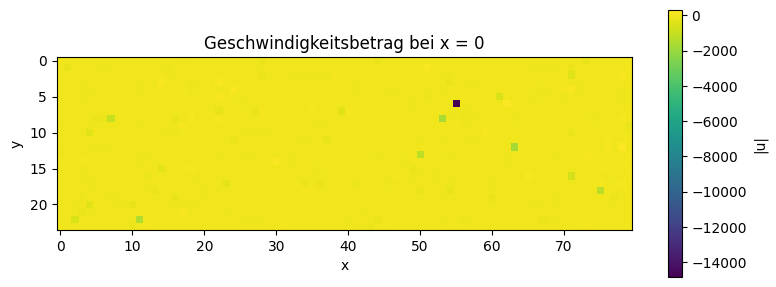

In [10]:
import matplotlib.pyplot as plt
# 💡 Schritt 1: u holen und Betrag berechnen
u = flow.units.convert_velocity_to_pu(flow.u())  # [3, Nx, Ny, Nz]
u_mag = torch.sqrt(u[0]**2+u[2]**2)  # [Nx, Ny, Nz]from typing import Union, List, Optional

u_mag = u[0]
# 💡 Schritt 2: Slice bei x = 0 extrahieren
slice_2d = u_mag[:, :, 0].transpose(0, 1) # [Ny, Nz]

# 💡 Schritt 3: Plotten
plt.figure(figsize=(8, 3))
plt.imshow(slice_2d.cpu().numpy())
plt.colorbar(label='|u|')
plt.title('Geschwindigkeitsbetrag bei x = 0')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.savefig(csvdir + "u.pdf")
plt.show()


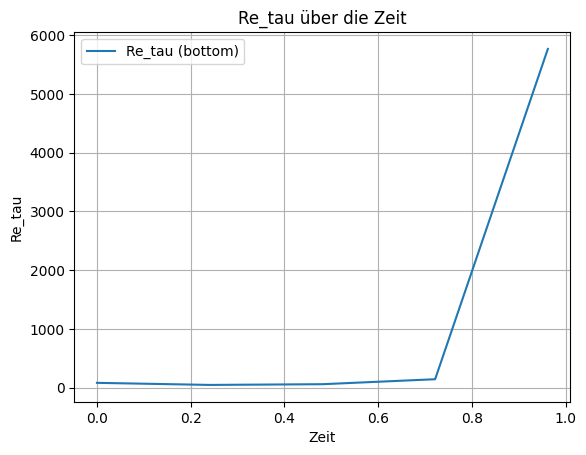

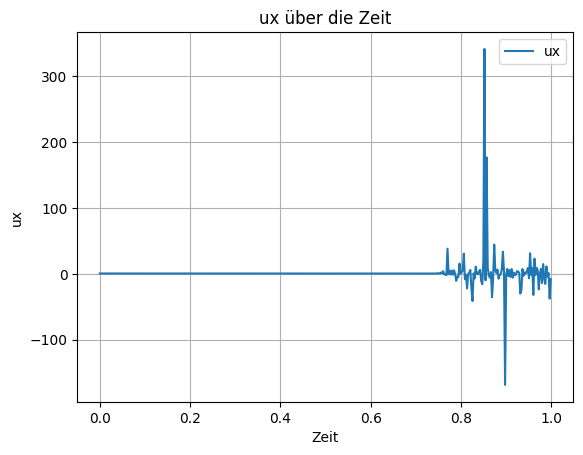

In [11]:



print(wq_bottom)
# Beispiel: Daten laden
data = (wq_bottom_arr+wq_top_arr)/2
time = data[:, 1]
re_tau = data[:, 4]
y_plus = data[:, 3]


plt.figure()
plt.plot(time, re_tau, label="Re_tau (bottom)")
plt.xlabel("Zeit")
plt.ylabel("Re_tau")
plt.legend()
plt.grid()
plt.title("Re_tau über die Zeit")
plt.savefig(csvdir + "retau.pdf")

plt.show()

plt.figure()
plt.plot(ux_mean_arr[:,1], flow.units.convert_velocity_to_pu(ux_mean_arr[:,2]), label="ux")
plt.xlabel("Zeit")
plt.ylabel("ux")
plt.legend()
plt.grid()
plt.title("ux über die Zeit")
plt.savefig(csvdir + "yplus.pdf")
plt.show()


In [12]:
print(u.shape)

torch.Size([3, 80, 24, 40])


In [13]:
import numpy as np

def viscosity_loglaw(Re_tau, uB=0.111, Lz=4.0, kappa=0.41, A=5.2):
    factor = (1 / kappa) * np.log(Re_tau) + A
    nu = (uB * Lz) / (2 * Re_tau * factor)
    return nu

def reynolds_number(char_length, char_velocity, viscosity):
    return char_length * char_velocity / viscosity

# Vorgaben
Re_tau = 180
uB = 1  # m/s
Lz = 1
H = "hi"     # Kanalhalbhöhe
L = 2 * H   # Kanalhöhe = 1.0

# Schritt 1: Viskosität berechnen
nu = viscosity_loglaw(Re_tau, uB=uB, Lz=Lz)
print(f"Viskosität (ν): {nu:.6e} m²/s")

# Schritt 2: Re klassisch berechnen
Re = reynolds_number(Lz, uB, nu)
print(f"Re = {Re:.2f}")


Viskosität (ν): 1.554806e-04 m²/s
Re = 6431.67


In [14]:
import torch
import matplotlib.pyplot as plt
import numpy as np


def plot_mean_velocity_profile(flow, plot_yplus=True, loglaw=True):
    """
    Plottet das mittlere Geschwindigkeitsprofil u_x(y) über die Kanalhöhe.

    Parameter:
    -----------
    flow : Flow-Objekt (z. B. ChannelFlow3D)
        Muss bereits eine Simulation enthalten.
    plot_yplus : bool
        Falls True, wird das Profil zusätzlich in y⁺/u⁺ dargestellt.
    loglaw : bool
        Falls True, wird das klassische Log-Law-Profil (u⁺ = (1/κ) log(y⁺) + B) mit geplottet.
    """

    # --- 1. Geschwindigkeit holen und u_x extrahieren
    u = flow.units.convert_velocity_to_pu(flow.u())  # [3, Nx, Ny, Nz] in physikalischen Einheiten
    ux = u[0]  # [Nx, Ny, Nz]

    # --- 2. Mittelung über x- und z-Richtung: ⟨u_x⟩(y)
    ux_mean_y = ux.mean(dim=(0, 2))  # → [Ny]

    # --- 3. y-Koordinaten in PU erzeugen
    Ny = flow.resolution[1]
    y_lu = torch.arange(Ny, device=flow.context.device)
    y_pu = flow.units.convert_length_to_pu(y_lu)

    # --- 4. Plot in physikalischen Einheiten
    plt.figure(figsize=(6, 4))
    plt.plot(y_pu.cpu(), ux_mean_y.cpu(), label=r'$\langle u_x \rangle(y)$ [m/s]')
    plt.xlabel("Höhe y [PU]")
    plt.ylabel(r"$\langle u_x \rangle$ [m/s]")
    plt.title("Mittlere x-Geschwindigkeit über Kanalhöhe")
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()

    # Optional: Wandkoordinaten (y⁺) und u⁺-Profil
    if plot_yplus:
        try:
            u_tau = flow.reporters["WallQuantities"].u_tau_mean
        except (KeyError, AttributeError):
            raise RuntimeError("Kein u_tau verfügbar! Stelle sicher, dass ein WallQuantities-Reporter vorhanden ist.")

        nu = flow.units.nu_pu
        y_plus = y_pu * u_tau / nu
        u_plus = ux_mean_y / u_tau

        # --- Optional: Log-Law-Profil zum Vergleich
        if loglaw:
            y_plus_log = np.linspace(30, y_plus.max().cpu().item(), 500)
            kappa = 0.41
            B = 5.2
            u_plus_log = (1 / kappa) * np.log(y_plus_log) + B

        # --- Plot in wandskalierten Einheiten
        plt.figure(figsize=(6, 4))
        plt.plot(y_plus.cpu(), u_plus.cpu(), label=r'$u^+(y^+)$')
        if loglaw:
            plt.plot(y_plus_log, u_plus_log, '--', label='Log-law')
        plt.xlabel(r"$y^+$")
        plt.ylabel(r"$u^+$")
        plt.title("Mittlere Geschwindigkeit in wandskalierten Einheiten")
        plt.grid(True)
        plt.tight_layout()
        plt.legend()
        plt.xscale("log")
        plt.show()


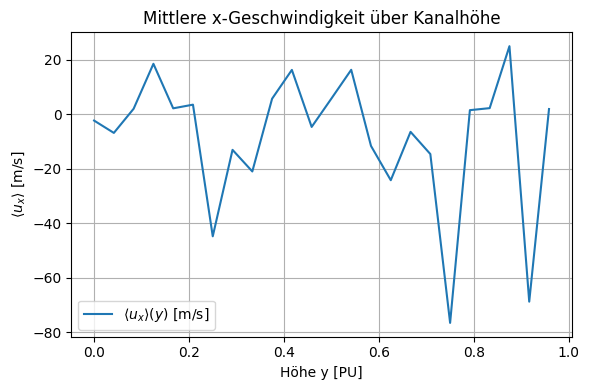

RuntimeError: Kein u_tau verfügbar! Stelle sicher, dass ein WallQuantities-Reporter vorhanden ist.

In [15]:
plot_mean_velocity_profile(flow, plot_yplus=True)


In [ ]:
print(flow is wfb_reporter.flow)
print(id(flow.f), id(wfb_reporter.flow.f))
